In [2]:

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.cluster import hierarchy
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from pathlib import Path
import matplotlib.patches as mpatches

sys.path.append('../../../')

from src.emotion.prediction.aggregates.train import HyperparaSearch
from src.emotion.prediction.aggregates.models import MODELS
from src.emotion.prediction.aggregates.test import load_models, generate_predictions, plot_predictions
from src.emotion.utils.constants import DATA_DIR

%matplotlib inline
plt.style.use('ggplot')

# set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#77b5e5', '#e46c81', '#97d2c5', '#e696cc', '#b6b6b6', '#a980b8', '#e9d66b'])

In [3]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset.csv')

In [4]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [5]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(104, 9351)

In [6]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)


(104, 9348)


In [7]:
# Detect outliers

# Check if all PERMA values are the same in each row
same_PERMA = (df['P'] == df['E']) & (df['E'] == df['R']) & (df['R'] == df['M']) & (df['M'] == df['A'])
# Remove the rows where all PERMA values are the same
df = df[~same_PERMA]
print(df.shape)

# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(104, 9348)
(104, 8759)
(104, 8759)


In [8]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [9]:
# Scale Features

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the dataframe and transform the dataframe
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [10]:
X.shape

(104, 8749)

In [11]:
corr_matrix = X.corr()

In [12]:
def plot_correlation_matrix(matrix):
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=0.7)
    sns.heatmap(corr_matrix, cmap="YlGnBu")

In [13]:
#plot_correlation_matrix(X)

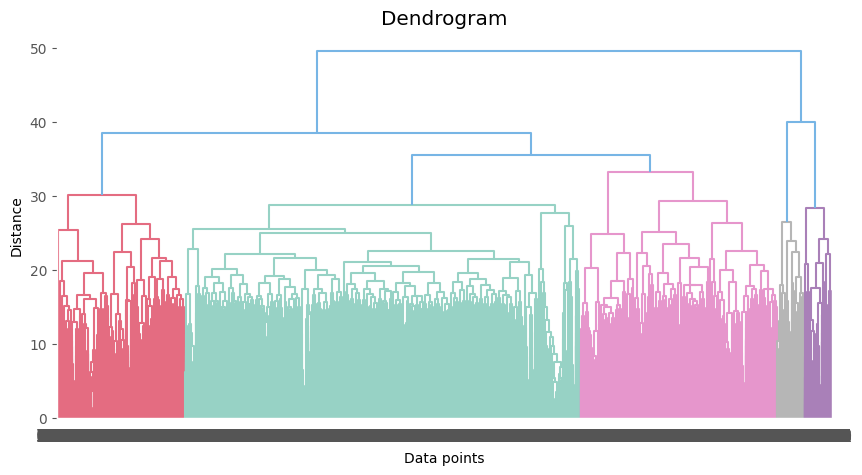

In [14]:
# Feature selection: runs in ~ 5min 
# Step 1: Identify feature clusters
# Create a dendrogram using hierarchical clustering
linkage = hierarchy.linkage(corr_matrix, method='complete')
plt.figure(figsize=(10, 5))
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
hierarchy.dendrogram(
    linkage,
    leaf_rotation=0.,  # Rotate x-axis labels
    leaf_font_size=12.,  # Font size for x-axis labels
)
plt.show()

In [15]:
# Get clusters from the dendrogram
max_d = 15 # Maximum distance between clusters
clusters = hierarchy.fcluster(linkage, max_d, criterion='distance')

clusters

array([ 73, 213, 171, ..., 311, 213, 213], dtype=int32)

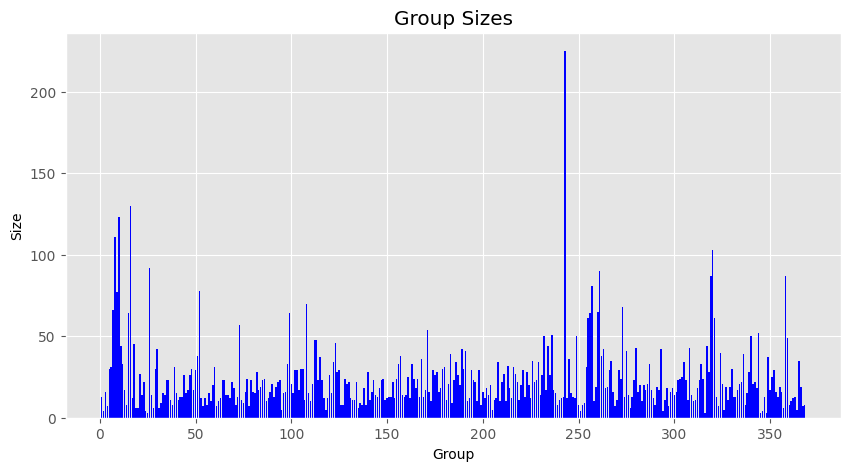

In [16]:
# Group columns by cluster
df = pd.DataFrame(corr_matrix)
df.columns = ['col_' + str(i) for i in range(df.shape[1])]
df['cluster'] = clusters
grouped = df.groupby('cluster')

# Get the size of each group
group_sizes = grouped.size()

# Plot the group sizes
plt.figure(figsize=(10,5))
plt.bar(x=group_sizes.index, height=group_sizes.values, color='blue')
plt.title('Group Sizes')
plt.xlabel('Group')
plt.ylabel('Size')
plt.show()

In [17]:
print(Y.shape)
print(X.shape)
print(len(clusters))

(104, 5)
(104, 8749)
8749


In [18]:
# Step 3: Calculate the correlation matrix between the columns of X and the columns of Y
corr_matrix = np.abs(np.corrcoef(X.T, Y.T)[:X.shape[1], X.shape[1]:])

# compute the row-wise averages of the matrix
avg_matrix = np.mean(corr_matrix, axis=1, keepdims=True)

# concatenate the average matrix with the group array
concat_matrix = np.concatenate([avg_matrix, clusters.reshape(len(clusters), 1)], axis=1)

# sort the concatenated matrix by group
sorted_matrix = concat_matrix[concat_matrix[:, -1].argsort()]

# find the maximum value in each group and its index
max_values = []
# iterate over the unique groups in the second column of the sorted matrix
for group in np.unique(sorted_matrix[:, 1]):
    # find the indices of rows that belong to the current group
    indices = np.where(sorted_matrix[:, 1] == group)[0]
    # get the maximum value in the first column for the current group
    max_value = np.max(sorted_matrix[indices, 0])
    # append the maximum value to the list
    max_values.append(max_value)
    
    
# find the indices of all the maximum values in the avg_matrix
max_indices = []
for max_value in max_values:
    indices = np.where(avg_matrix == max_value)[0]
    max_indices.extend(indices)

X_filtered = X.iloc[:, max_indices]
print(X_filtered.shape)



(104, 371)


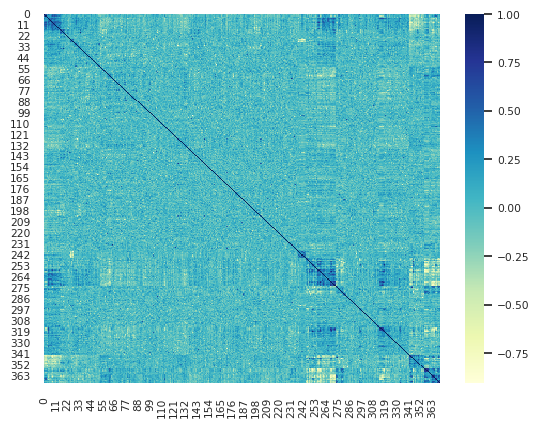

In [19]:
plot_correlation_matrix(X_filtered)

In [20]:
# def get_selected_voting_features_multi(Y, X_filtered, filter_methods, k):
#     feature_counts = np.zeros(X_filtered.shape[1])
    
#     #print(Y.shape[1])
#     print(len(Y.T))
    
#     for i in range(len(Y.T)):
#         y_i = Y.iloc[:, i]
        
#         for method_name, method in filter_methods.items():
#             pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
#             pipeline.fit(X_filtered, y_i)
#             selected_i = pipeline.named_steps[method_name].get_support(indices=True)
            
#             # Increment the count for each selected feature
#             for index in selected_i:
#                 feature_counts[index] += 1
                
#     # Get the indices of the top k features with the most counts
#     top_k_features = np.argsort(feature_counts)[-k:]
    
#     return top_k_features

In [21]:
# filter_methods = {
#     'f_regression': SelectKBest(f_regression, k=10),
#     'mutual_info_regression': SelectKBest(mutual_info_regression, k=10),
#     'variance_threshold': VarianceThreshold(threshold=0.1),
# }

# all_selected_features = get_selected_voting_features_multi(Y, X_filtered, filter_methods, k=15)

# print("Fused selected features:", all_selected_features)


In [22]:
# X_final = X_filtered.iloc[:, list(set(all_selected_features))]
# plot_correlation_matrix(X_final)
# column_names = X_final.columns.tolist()
# print(column_names)

In [23]:
# models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "GradientBoostingRegressor", "SVR"]

# for name in models_to_drop:
#     for i in range(len(MODELS)):
#         if MODELS[i]["name"] == name:
#             del MODELS[i]
#             break
        
# for model in MODELS:
#     print(model["name"])

In [24]:
# # Runs in ~5 min for n_fols=5
# search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], n_folds=5, n_jobs=-1)

# results = search.run(X_final, Y, save=False)

In [25]:
# best_feats_dict = {model[0]['name']: model[0]['best_feats'] for model in results}
# #print(best_feats_dict)

In [26]:
# for model in best_feats_dict.keys():
#     print(f"Algorithm: {model}")
#     # Get the feature importance values for the algorithm
#     feat_imp_vals = best_feats_dict[model]
#     # Map the feature importance values with the feature list using a dictionary comprehension
#     feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
#     # Rank the features by their importance value in descending order
#     ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
#     # Print the ranked features
#     #print(ranked_feats)

In [27]:
# eval_metric = "mean_absolute_error"

# # Plot the results
# mae_scores = [
#     rd["score"]
#     for result_list in results
#     for rd in result_list
#     if rd["metric"] == eval_metric
# ]
# model_names = [
#     rd["name"]
#     for result_list in results
#     for rd in result_list
#     if rd["metric"] == eval_metric
# ]
# plt.bar(model_names, mae_scores)
# plt.title("Mean Absolute Error Scores")
# plt.xlabel("Model")
# plt.ylabel("Score")
# plt.xticks(rotation=45) 
# plt.show()

In [28]:
# Print the model with the lowest score
# best_model = min(
#     [
#         min(
#             sublist,
#             key=lambda x: x["score"]
#             if x["metric"] == eval_metric
#             else float("inf"),
#         )
#         for sublist in results
#     ],
#     key=lambda x: x["score"],
# )
# print(f"Best model: {best_model['name']}")
# print(f"Best params: {best_model['params']}")
# print(f"Best Score: {best_model['score']}")

In [29]:
def get_selected_voting_features_uni(Y, X_filtered, filter_methods, k):
    feature_counts = np.zeros(X_filtered.shape[1])
        
    for method_name, method in filter_methods.items():
        pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
        pipeline.fit(X_filtered, Y)
        selected_i = pipeline.named_steps[method_name].get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
                
    # Get the indices of the top k features with the most counts
    top_k_features = np.argsort(feature_counts)[-k:]
    
    return top_k_features

In [30]:
# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=10),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=10),
    'variance_threshold': VarianceThreshold(threshold=0.1),
}

# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_uni(Y.iloc[:, i], X_filtered, filter_methods, k=10)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])


P : [291 302 124 228  93 144 292 185 233 329]
E : [291  61  41 108 329 159 216 111 320 164]
R : [ 31 117 329 141 305 234 233 259 267  73]
M : [ 62  61 308 233 127 136 329  29 345 133]
A : [256 108 116 233  49 226 329 204 289  92]


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, Y, test_size=0.2, random_state=42)

In [32]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    X_test_final = X_test.iloc[:, list(set(selected_features))]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)

P : ['Brightness__fft_coefficient__attr_"imag"__coeff_36', 'Arousal__fft_coefficient__attr_"real"__coeff_31', 'Velocity__fft_coefficient__attr_"real"__coeff_51', 'Brightness__large_standard_deviation__r_0.15000000000000002', 'Surprise__fft_coefficient__attr_"angle"__coeff_43', 'Fear__fft_coefficient__attr_"real"__coeff_89', 'Angry__fft_coefficient__attr_"imag"__coeff_47', 'Angry__fft_coefficient__attr_"angle"__coeff_94', 'Happy__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'Sad__fft_coefficient__attr_"real"__coeff_61']
E : ['Happy__benford_correlation', 'Brightness__fft_coefficient__attr_"imag"__coeff_36', 'Velocity__fft_coefficient__attr_"angle"__coeff_36', 'Surprise__fft_coefficient__attr_"angle"__coeff_43', 'Disgust__fft_coefficient__attr_"real"__coeff_15', 'Surprise__fft_coefficient__attr_"angle"__coeff_92', 'Valence__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'Dominance__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'Sad__ratio_beyo

In [33]:
SAVE_DIR = Path("/home/moritz/Workspace/masterthesis/model/custom_models/univariate/big")

eval_metric = "mean_absolute_error"

In [34]:
models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "SVR"]

for name in models_to_drop:
    for i in range(len(MODELS)):
        if MODELS[i]["name"] == name:
            del MODELS[i]
            break
        
for model in MODELS:
    print(model["name"])

RandomForestRegressor
ExtraTreesRegressor
GradientBoostingRegressor
AdaBoostRegressor
LinearRegression
Ridge
Lasso
ElasticNet
BayesianRidge
CatBoostRegressor
XGBRegressor


In [35]:
results_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR / perma_dim
    search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")
    results = search.run(X_final["train"], Y_train[perma_dim], save=True)
    results_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P
Models for RandomForestRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/RandomForestRegressor.joblib
Models for ExtraTreesRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/ExtraTreesRegressor.joblib
Models for GradientBoostingRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/GradientBoostingRegressor.joblib
Models for AdaBoostRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/AdaBoostRegressor.joblib
Models for LinearRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/LinearRegression.joblib
Models for Ridge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/Ridge.joblib
Models for Lasso saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/Lasso.joblib
Models for ElasticNet saved to /home/moritz/Workspa

In [36]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR / perma_dim
    models = load_models(models_path)
    perma_models[perma_dim] = models

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def generate_predictions(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate mean squared error and mean absolute error
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        results[model_name] = {"mae": mae, "mse": mse, "y_pred": y_pred}
    return results

In [38]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results
    # for model_name, result in results.items():
    #     print(f"{dim} - {model_name}: MAE - {result['mae']}, MSE - {result['mse']}")
    

In [39]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["mae"] < curr_mae:
            curr_mae = results[model]["mae"]
            best_results[dim] = {"model": model, "mae": results[model]["mae"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'BayesianRidge', 'mae': 0.6640513140701447, 'preds': array([ 0.23213957,  0.22060696, -0.83075329,  0.76505115,  0.66131177,
        0.25347039, -0.16727937, -0.62143709, -0.06683428, -0.59719024,
        0.15248679,  0.98409576, -0.17532183,  0.14287999, -0.72892707,
        0.09768282,  0.48114342, -0.4870922 ,  0.66223597, -0.44370629,
        0.45373533])}, 'E': {'model': 'Lasso', 'mae': 0.6632412855098654, 'preds': array([-6.60226176e-01, -3.04779802e-01, -6.39992606e-02, -1.95150993e-01,
       -2.29110644e-02, -1.05359827e+00,  6.61895854e-01,  2.94717367e-01,
       -4.83645239e-01,  2.96492022e-01, -5.63805748e-01, -8.08311274e-01,
       -2.48566486e-01,  4.59445064e-01, -8.67458908e-01,  1.57348943e-04,
        7.18471349e-01, -6.53886674e-02, -6.44457540e-01, -5.47871742e-01,
        3.51806459e-01])}, 'R': {'model': 'LinearRegression', 'mae': 0.7315390416281096, 'preds': array([-0.3129314 ,  0.90357894,  0.45287283,  0.43133737,  1.65782143,
       -3.00692

In [40]:
best_feats_dict = {}

for dim, results in results_dict.items():
    best_feats_dict[dim] = {model[0]['name']: {"feat_imp": model[0]['best_feats'], "score": model[0]["score"]}  for model in results}

best_feats_dict_dim = {}
    
for dim in ['P', 'E', 'R', 'M', 'A']:
    model = best_results[dim]["model"]
    feat_imp = abs(best_feats_dict[dim][model]["feat_imp"])
    best_feats_dict_dim[dim] = feat_imp

best_feats_dict_dim

{'P': array([0.22461818, 0.47338205, 0.18890185, 0.36597313, 0.63830771,
        0.95262736, 0.14254342, 0.54145852, 1.05691352, 0.15866531]),
 'E': array([0.50457852, 0.93003544, 0.37098215, 0.42356105, 1.70429928,
        0.93461228, 0.47571422, 0.52367606, 0.75403299, 0.3387325 ]),
 'R': array([0.28235325, 0.02172536, 2.59018607, 0.30369864, 1.70615493,
        1.41359515, 1.05892798, 0.38111935, 0.7649371 , 0.97342596]),
 'M': array([0.14948879, 0.1348047 , 0.00213464, 0.04831867, 0.09663507,
        0.14330729, 0.03124604, 0.08212241, 0.21456918, 0.0973732 ]),
 'A': array([0.14809245, 0.22530106, 0.14301344, 0.00153666, 0.03068225,
        0.13355714, 0.06746478, 0.04076257, 0.0992678 , 0.11032184])}

In [41]:
ranked_feats_dict = {}

for (dim, feat_imp_vals), (dim, X_final) in zip(best_feats_dict_dim.items(), feature_sets.items()):
    # Map the feature importance values with the feature list using a dictionary comprehension
    column_names = X_final["train"].columns.tolist()
    feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
    # Rank the features by their importance value in descending order
    ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
    ranked_feats_dict[dim] = ranked_feats

/tmp/ipykernel_382536/4206057206.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


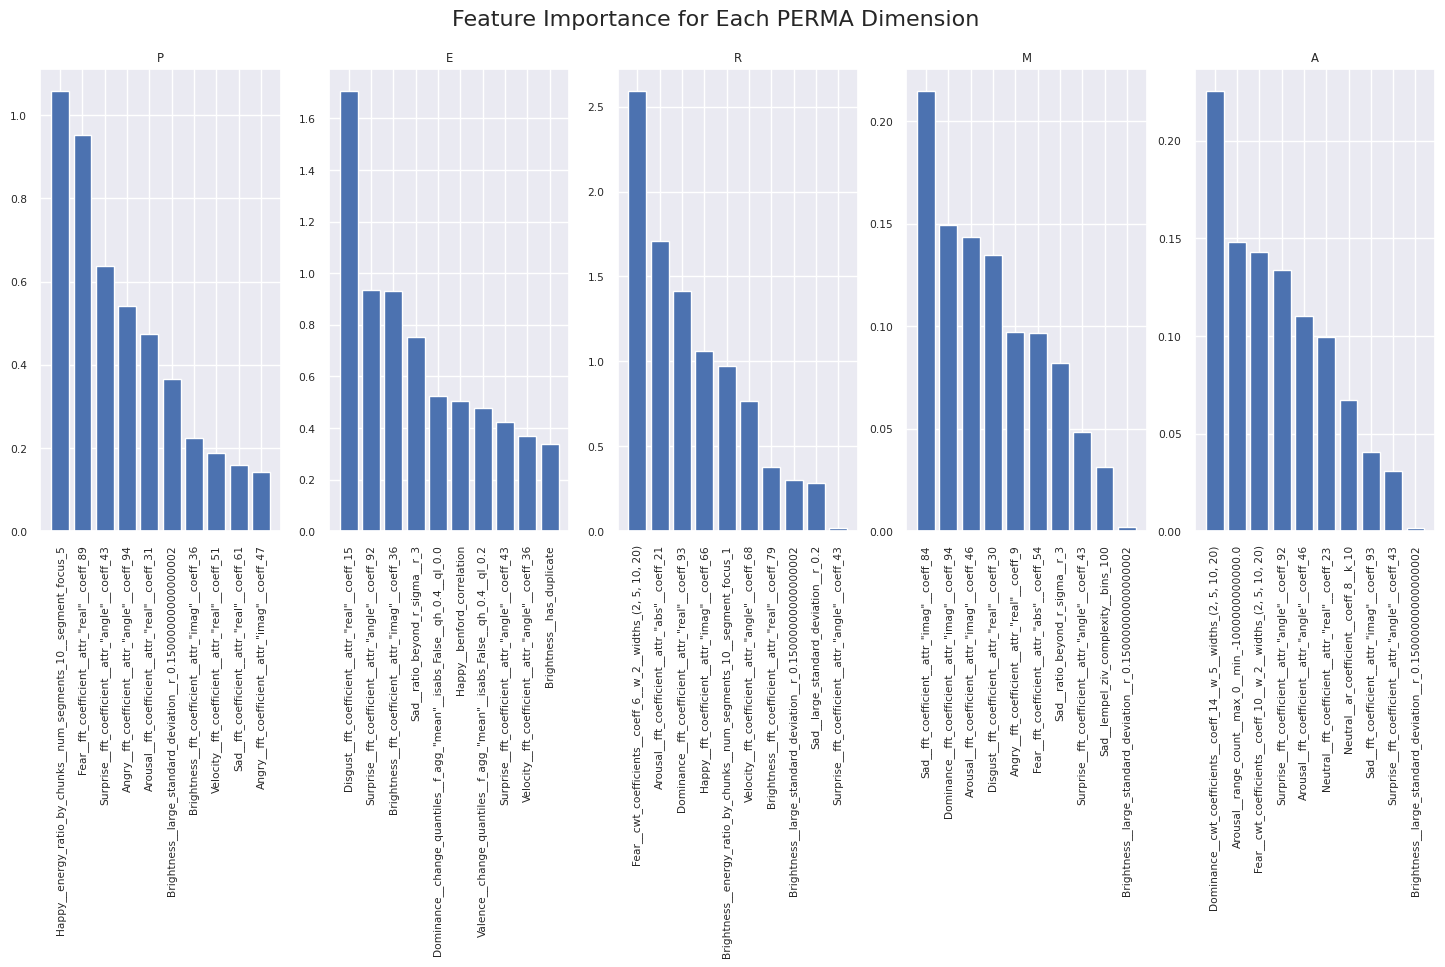

In [52]:
#Separate the feature names and importance scores for each dimension PERMA
P_features, P_scores = zip(*ranked_feats_dict["P"])
E_features, E_scores = zip(*ranked_feats_dict["E"])
R_features, R_scores = zip(*ranked_feats_dict["R"])
M_features, M_scores = zip(*ranked_feats_dict["M"])
A_features, A_scores = zip(*ranked_feats_dict["A"])


#Create a bar plot for each dimension PERMA
fig, axs = plt.subplots(1, 5, figsize=(18, 6))
axs[0].bar(P_features, P_scores)
axs[0].set_title("P")
axs[1].bar(E_features, E_scores)
axs[1].set_title("E")
axs[2].bar(R_features, R_scores)
axs[2].set_title("R")
axs[3].bar(M_features, M_scores)
axs[3].set_title("M")
axs[4].bar(A_features, A_scores)
axs[4].set_title("A")

#Set common axis labels and title
fig.suptitle("Feature Importance for Each PERMA Dimension", fontsize=16)
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

In [43]:
# Baseline:
Y_baseline = np.full_like(Y_test, Y_test.mean(axis=0).transpose())
mae_baseline = mean_absolute_error(Y_test, Y_baseline, multioutput='raw_values')

print(f"Baseline MAE for each dimension: {mae_baseline}")

Baseline MAE for each dimension: [0.84705643 0.83483656 0.82358261 0.78212217 0.77659055]


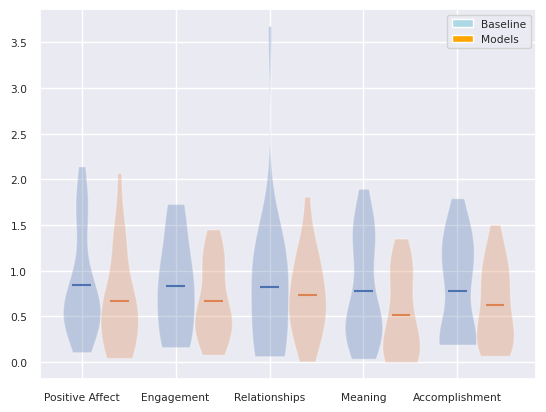

In [44]:
# Calculate the errors between the actual values and the baseline predictions
baseline_errors = abs(Y_test - Y_baseline)

# Calculate the errors for each model and each dimension
model_errors = pd.DataFrame()

# Calculate the errors for each model and each dimension
for dim in ['P', 'E', 'R', 'M', 'A']:
    err = abs(Y_test[dim] - best_results[dim]['preds'])
    errors = pd.DataFrame({'errors': err})
    model_errors = pd.concat([model_errors, errors], axis=1)

# Concatenate baseline and model errors
all_errors = [baseline_errors, model_errors]

# Create a combined boxplot
fig, ax = plt.subplots()
colors = ['lightblue', 'orange']
labels = ['Baseline', 'Models']

for i, error_df in enumerate(all_errors):
    position = np.arange(1, len(error_df.columns) + 1) + (i * 0.4)
    #ax.boxplot(error_df, positions=position, widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.violinplot(error_df, positions=position, widths=0.4, showmedians=False, showextrema=False, showmeans=True)

# Define the labels for the x-axis
perma = ['Positive Affect', 'Engagement', 'Relationships', 'Meaning', 'Accomplishment']

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(1, len(perma) + 1))
ax.set_xticklabels(perma)

# Create the legend patches and labels
patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the plot
ax.legend(handles=patches, loc='upper right')

Text(0.5, 1.0, 'PERMA Dimension MAE Scores')

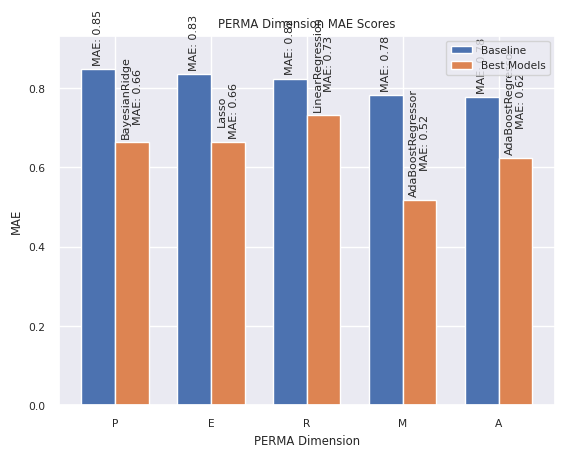

In [45]:
# Print the best model for each PERMA dimension
best_mae_values = [v['mae'] for v in best_results.values()]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
ax.bar(np.arange(len(perma_dimensions)), mae_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_mae_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimension')

# Set the y-axis label and limits
ax.set_ylabel('MAE')
ax.set_ylim([0, max(np.max(mae_baseline), np.max(best_mae_values))*1.1])

# Add the model names and MAE values above each bar
for i, v in enumerate(mae_baseline):
    ax.text(i, v+0.01, f"MAE: {v:.2f}", rotation=90, ha='center', va='bottom', fontsize=8)
    ax.text(i+bar_width, best_mae_values[i]+0.01, f"{best_results[perma_dimensions[i]]['model']}\nMAE: {best_mae_values[i]:.2f}", rotation=90, ha='center', va='bottom', fontsize=8)

# Add a legend and title
ax.legend()
ax.set_title('PERMA Dimension MAE Scores')

In [46]:
model_dict = {
    "P": "LinearRegression",
    "E": "LinearRegression",
    "R": "Lasso",
    "M": "LinearRegression",
    "A": "LinearRegression",
}



Text(0.5, 1.0, 'PERMA')

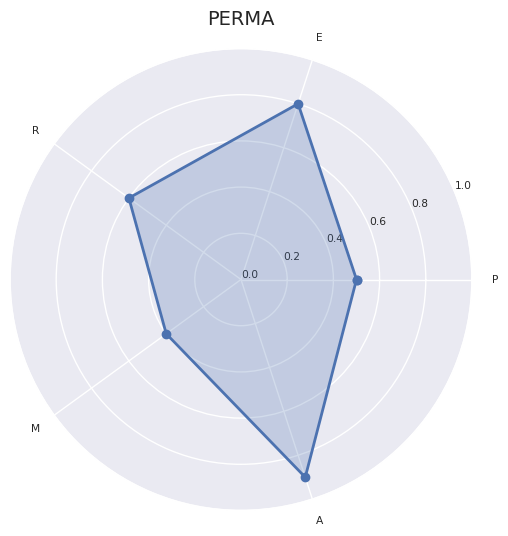

In [47]:
labels = ['P', 'E', 'R', 'M', 'A']
data = np.array([0.5, 0.8, 0.6, 0.4, 0.9])

# Calculate the angle for each label
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# Close the plot
data = np.concatenate((data, [data[0]]))
angles = np.concatenate((angles, [angles[0]]))

# Create the figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Plot the data
ax.plot(angles, data, 'o-', linewidth=2)
ax.fill(angles, data, alpha=0.25)

# Set the labels
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylim(0, 1)
plt.title('PERMA', fontsize=14)